# **CAPP 30254: MLPubPol HW 1 - Ibrahim Gabr**

## Questions:

1. Read Data: For this assignment, assume input is CSV and write a function that can read a csv into python

2. Explore Data: You can use the code you wrote for assignment 1 here to generate distributions and data summaries.

3. Pre-Process Data: For this assignment, you can limit this to filling in missing values for the variables that have missing values. You can use any simple method to do it (use mean to fill in missing values).

4. Generate Features/Predictors: For this assignment, you should write one function that can discretize a continuous variable and one function that can take a categorical variable and create binary/dummy variables from it. Apply them to at least one variable each in this data.

5. Build Classifier: For this assignment, select any classifier you feel comfortable with (Logistic Regression for example)

6. Evaluate Classifier: you can use any metric you choose for this assignment (accuracy is the easiest one). Feel free to evaluate it on the same data you built the model on (this is not a good idea in general but for this assignment, it is fine). We haven't covered models and evaluation yet, so don't worry about creating validation sets or cross-validation. 

In [1]:
%matplotlib inline
%pylab inline
%run general_functions.py
%run classification_functions.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = pd.read_csv("credit-data.csv")
dictionary = pd.read_excel("Data Dictionary.xls")
dictionary
del dataset['PersonID']

The purpose of this assignment is to create a simple Machine Learning Pipeline. The data disseminated contained different financial features that would eventually be used to build classifer to predict serious financial deliquency. The features can be seen below.

NOTE: This notebook contains 'barebones' code. For a full overview of all code used in this assignment, please consult the classification_functions.py and general_functions.py

In [3]:
dictionary

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,zipcode,zipcode of the borrower,interget/string
5,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer


One of our key concerns from the very start is to prevent information leakage via imputation and data cleaning. As such, we will split out dataset into training and test and only impute/clean based on their respective subgroups. No cleaning or imputation will be required for our label variable as there are no values missing.

The code below will show how I extracted the label and split the Dataset. This was a simple process.

In [4]:
label = pd.DataFrame(dataset['SeriousDlqin2yrs'])
del dataset['SeriousDlqin2yrs']
features = dataset

In [5]:
numpy.random.seed(seed=1) #setting seed for reporducibility
is_test = np.random.uniform(0, 1, len(dataset)) > 0.80 #80% used to train
X_train = features[is_test==False]
X_test = features[is_test==True]
y_train = label[is_test==False]
y_test = label[is_test == True]

Let's check out dimensions of all sets to make sure we have spilt appropriately!

In [6]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape) #No imputation required.
print(y_test.shape) #No imputation required.

(29956, 11)
(120044, 11)
(120044, 1)
(29956, 1)


# Let's start our analysis! Part 1-4

In this section I will explore both the test and train data indepedently. This is the start of my data preprocessing phase. This section will address nuances in the data and any workarounds/fixes that need to be made.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bda01d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114968e10>]], dtype=object)

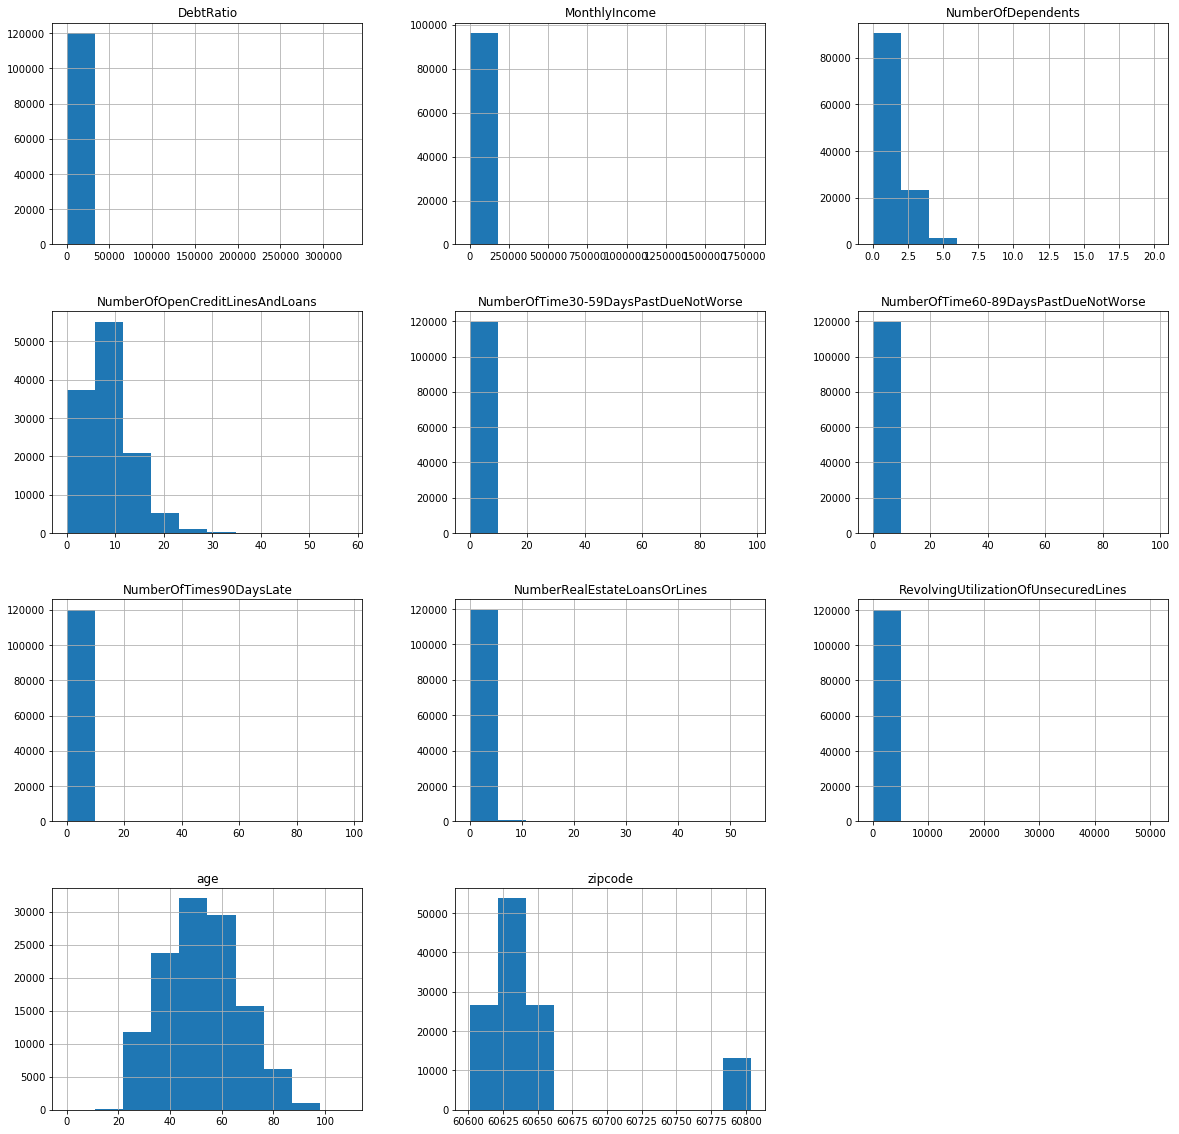

In [7]:
X_train.hist(figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114a929b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112e7e0b8>]], dtype=object)

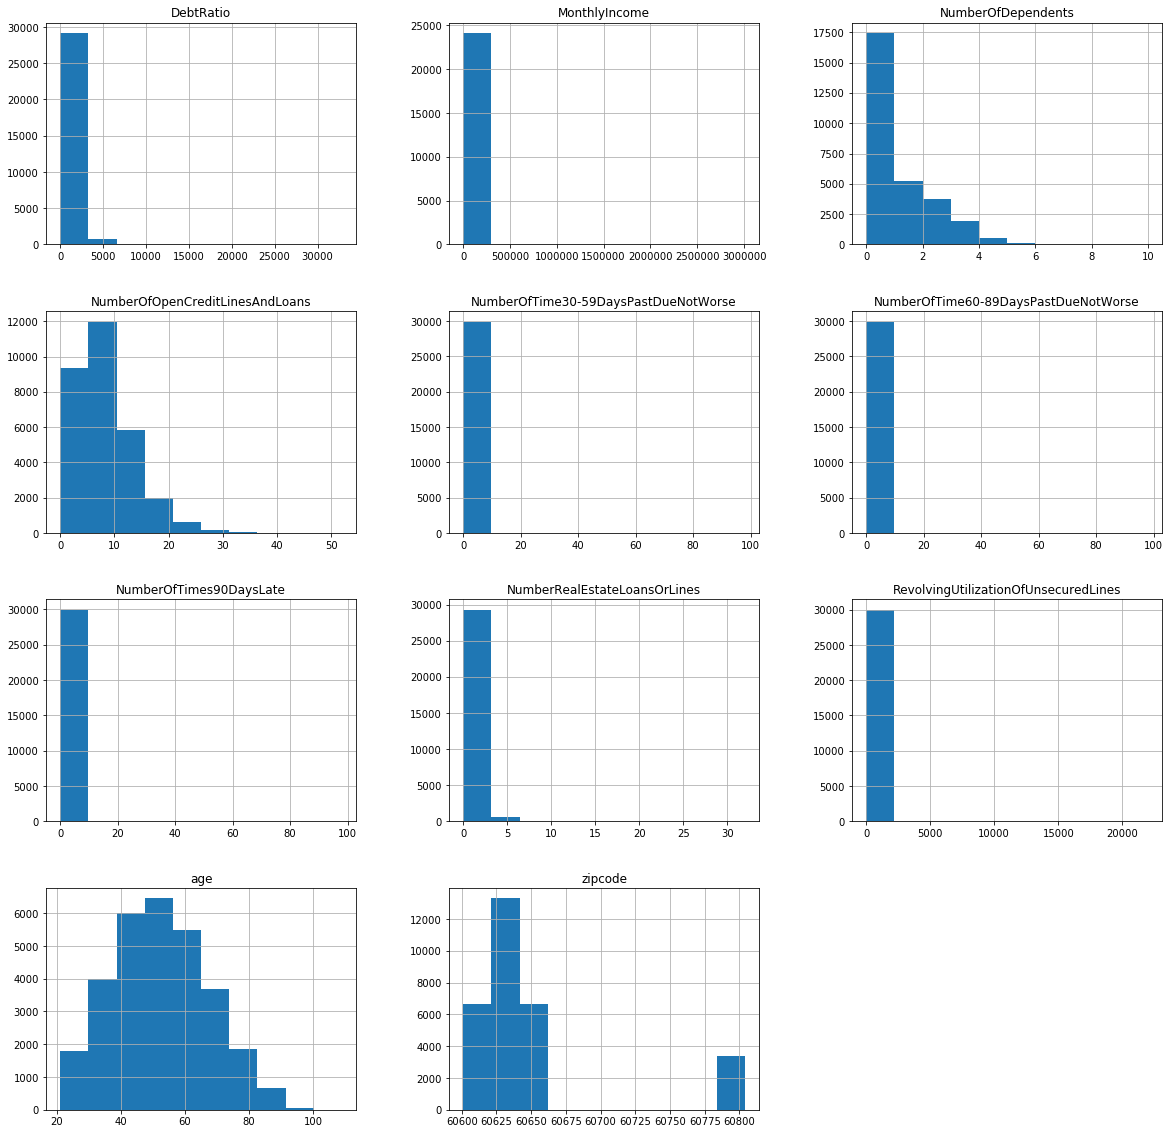

In [8]:
X_test.hist(figsize=(20,20))

In [9]:
analyze(X_train, X_test, "RevolvingUtilizationOfUnsecuredLines")

Training Set: 

Max:  50708.0
Mean 6.51042576115

Missing Values:  0

Testing Set: 

Max:  22000.0
Mean:  4.19709434265

Missing Values:  0


Training Set:

From the above, we see that the max value is 50708! This means that there are individuals with that owe a whopping 50,708% of their total credit lines. At first glance, this may seem unreasonable. However, when we consider that this data set my contai business owners adn students, it becomes  much more reasonable. For example, think about the debt ratio for a medical student. The mean represents a more reasonable 6%

Testing Set:

Max value of 22000% - similar reasoning as above.

The percentages just calculated measures how much of your available credit is currently being used. These are some of the most important factors in a credit score, making up almost 30% of your score (I researched this). It is advised that for a healthy credit score, this be kept under 10% at all times.

In [10]:
analyze(X_train, X_test,'age')

Training Set: 

109.0
0.0
52.2909266602

Missing Values:  0

Testing Set: 

109.0
21.0
52.3123581253

Missing Values:  0


It doesnt really make sense to have an individual with an age of 0 in out Training set. From below, we can see that there is only 1 entry with this odd age in addition to odd values for other columns. We will drop the row from our dataset. Let's go ahead and impute this right now

In [11]:
X_train.groupby('age').count().head()

,RevolvingUtilizationOfUnsecuredLines,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
age,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1
21,155,155,155,155,116,155,155,155,155,131
22,341,341,341,341,265,341,341,341,341,308
23,506,506,506,506,413,506,506,506,506,473
24,669,669,669,669,537,669,669,669,669,624


In [12]:
X_train[X_train['age']==0] #index 65695 with age to be imputed with the mean age.

,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,1.0,0,60629,1,0.436927,6000.0,6,0,2,0,2.0


In [13]:
X_train['age'].replace(0, X_train['age'].mean(), inplace=True)

In [14]:
X_train.loc[65695] #Successfuly imputed.

RevolvingUtilizationOfUnsecuredLines        1.000000
age                                        52.290927
zipcode                                 60629.000000
NumberOfTime30-59DaysPastDueNotWorse        1.000000
DebtRatio                                   0.436927
MonthlyIncome                            6000.000000
NumberOfOpenCreditLinesAndLoans             6.000000
NumberOfTimes90DaysLate                     0.000000
NumberRealEstateLoansOrLines                2.000000
NumberOfTime60-89DaysPastDueNotWorse        0.000000
NumberOfDependents                          2.000000
Name: 65695, dtype: float64

In [15]:
analyze(X_train, X_test,"zipcode")

Training Set: 

[60644 60637 60601 60625 60629 60804 60657 60618]

Missing Values:  0

Test Set: 

[60804 60625 60629 60657 60618 60644 60637 60601]

Missing Values:  0


There are only 8 unique zipcodes in our dataset, however, there are 94 unique zip codes in Chicago. Thus I will be dropping the Zip Code feature for use in the predictive model. While Zip Code may be useful for the predictive purposes of this specific dataset, if we wanted to use the model we build here for other similar Chicago data then including only this subset of Zip Codes would damage the accuracy of our model.

In [16]:
del X_train['zipcode']
del X_test['zipcode']

In [17]:
analyze(X_train, X_test,"NumberOfTime30-59DaysPastDueNotWorse")

Training Set: 

count    120044.000000
mean          0.425977
std           4.265522
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

Missing Values:  0

Test Set: 

count    29956.000000
mean         0.401222
std          3.887659
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

Missing Values:  0



In [18]:
analyze(X_train, X_test, "DebtRatio")

Training Set: 

count    120044.000000
mean        359.641845
std        2215.827580
min           0.000000
25%           0.174713
50%           0.366280
75%           0.872100
max      329664.000000
Name: DebtRatio, dtype: float64

Missing Values:  0

Test Set: 

count    29956.000000
mean       326.409257
std       1057.152821
min          0.000000
25%          0.176398
50%          0.367255
75%          0.852370
max      32843.000000
Name: DebtRatio, dtype: float64

Missing Values:  0



In [19]:
analyze(X_train, X_test,"RevolvingUtilizationOfUnsecuredLines")

Training Set: 

Max:  50708.0
Mean 6.51042576115

Missing Values:  0

Testing Set: 

Max:  22000.0
Mean:  4.19709434265

Missing Values:  0


In [20]:
analyze(X_train, X_test,'MonthlyIncome')

Training Set: 

count    9.615700e+04
mean     6.653152e+03
std      1.103299e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.250000e+03
max      1.794060e+06
Name: MonthlyIncome, dtype: float64

Mean:  6653.152126210261

Median:  5400.0

Missing Values:  23887

Test Set: 

count    2.411200e+04
mean     6.738292e+03
std      2.338102e+04
min      0.000000e+00
25%      3.355750e+03
50%      5.353500e+03
75%      8.200250e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

Mean:  6738.291680491042

Median:  5353.5

Missing Values:  5844


It is important to understand that the debt ratio's are calculated on Monthly Incomes. Thus, very high levels of debt ratio and revolving utilization of credit make sense for individuals with low/fluctuating incomes. Graphically, we see that debt ratio and revolving utilization of unsecured lines spike near values of 0. These could be individuals pursuing full time education (e.g. Doctors) and thus have 0 income, but extremely high levels of debt.

We should also consider empirical evidence - many american households have a tendency to live outside their means -  as such, these figures begin to make more sense when we consider that individuals may be paying the bare minimum on outstanding balances. This leads to very high APR rates kicking in as well as compound interest on debt.

From the above, it looks like we have missing data! Since there is evidence of right skew (Mean > Median). I will be imputing with the Median as this is less sensitive to outliers.

In [21]:
X_train['MonthlyIncome'] = X_train['MonthlyIncome'].fillna(X_train['MonthlyIncome'].median())
X_test['MonthlyIncome'] = X_test['MonthlyIncome'].fillna(X_test['MonthlyIncome'].median())

In [22]:
analyze(X_train, X_test,"NumberOfOpenCreditLinesAndLoans")

Training Set: 

count    120044.000000
mean          8.444537
std           5.137646
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Missing Values:  0

Test Set: 

count    29956.000000
mean         8.485712
std          5.179054
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         52.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Missing Values:  0



In [23]:
analyze(X_train, X_test,"NumberOfTimes90DaysLate")

Training Set: 

count    120044.000000
mean          0.271709
std           4.242718
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

Missing Values:  0

Test Set: 

count    29956.00000
mean         0.24299
std          3.86111
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         98.00000
Name: NumberOfTimes90DaysLate, dtype: float64

Missing Values:  0



In [24]:
analyze(X_train, X_test,"NumberRealEstateLoansOrLines")

Training Set: 

count    120044.000000
mean          1.018960
std           1.130722
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

Missing Values:  0

Test Set: 

count    29956.000000
mean         1.015356
std          1.125966
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         32.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

Missing Values:  0



In [25]:
analyze(X_train, X_test,"NumberOfTime60-89DaysPastDueNotWorse")

Training Set: 

count    120044.000000
mean          0.246826
std           4.229001
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

Missing Values:  0

Test Set: 

count    29956.000000
mean         0.214581
std          3.845118
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

Missing Values:  0



In [26]:
analyze(X_train, X_test,"NumberOfDependents")

Training Set: 

count    116917.000000
mean          0.758051
std           1.114435
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

Missing Values:  3127

Test Set: 

count    29159.000000
mean         0.753901
std          1.117704
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: NumberOfDependents, dtype: float64

Missing Values:  797



In [27]:
print("Training Set: ")
print()
print(X_train['NumberOfDependents'].mode())
print()
print("Testing Set: ")
print()
print(X_test['NumberOfDependents'].mode())

Training Set: 

0    0.0
dtype: float64

Testing Set: 

0    0.0
dtype: float64


It seems that the most common number of depedents in both sets are 0. I will impute missing values with 0.

In [28]:
X_train['NumberOfDependents'] = X_train["NumberOfDependents"].fillna(int(X_train['NumberOfDependents'].mode()[0]))
X_test['NumberOfDependents'] = X_test["NumberOfDependents"].fillna(int(X_test['NumberOfDependents'].mode()[0]))

In [29]:
print("Training Set: ")
print()
print("Missing Values in Set: ")
print()
print(X_train.isnull().sum())
print("Test Set: ")
print()
print("Missing Values in Set: ")
print()
print(X_test.isnull().sum())

Training Set: 

Missing Values in Set: 

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64
Test Set: 

Missing Values in Set: 

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


Another thing to notice is that there are records where individuals have 0 income.

It is important at this juncture to also realise that many of the data points can be viewed as outliers, in that there are many monthly income values that are extremely high.

For this reason, it is important to discretize our continuous variable so that we can have a look at the overall structure of the data!

There are also no negative values for any of our features.

Now, let's create some visulisations of our data. Since we have so many rows of data, it will be helpful to create some bins!

Lets make a bins function - this will discretize our continuous variables.

First we will have to recombine our data!

In [30]:
combined_y = y_train.append(y_test)
combined_x = X_train.append(X_test)
combined_dataset = pd.concat([combined_y, combined_x], axis=1)

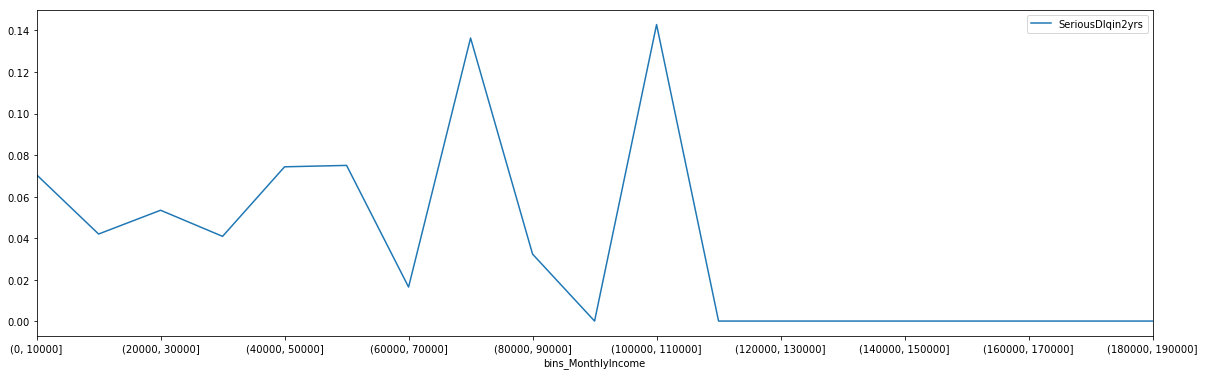

In [31]:
income_bins = range(0, 200000, 10000)
income_bucket = generate_bins(combined_dataset, 'MonthlyIncome', income_bins)
average_visualisation_groups(combined_dataset, [income_bucket, "SeriousDlqin2yrs"], income_bucket)

From the above chart we can see that those individuals falling in the 70-80K and 95-110K bucket tend to suffer from serious financial issues.

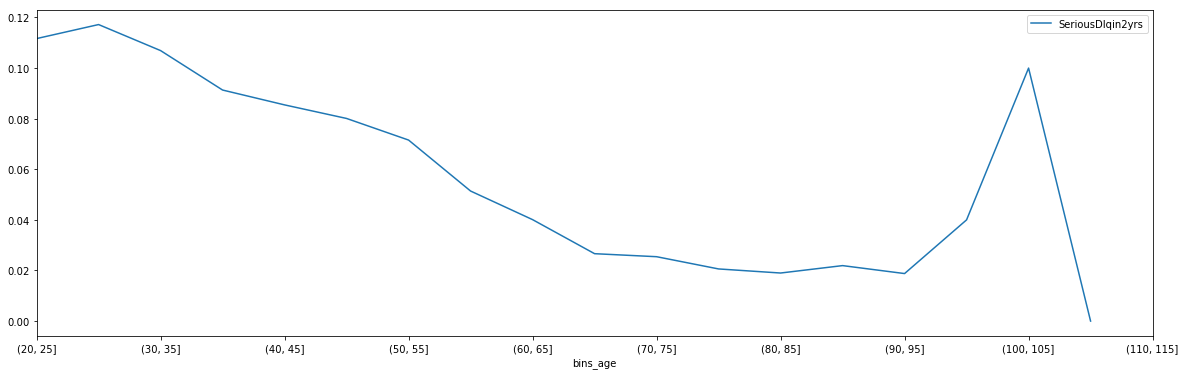

In [32]:
age_bins = range(20,120, 5)
age_bucket = generate_bins(combined_dataset, 'age', age_bins)
average_visualisation_groups(combined_dataset, [age_bucket, "SeriousDlqin2yrs"], age_bucket)

The above chart spikes towards the 90+ age group. This might due health care costs.

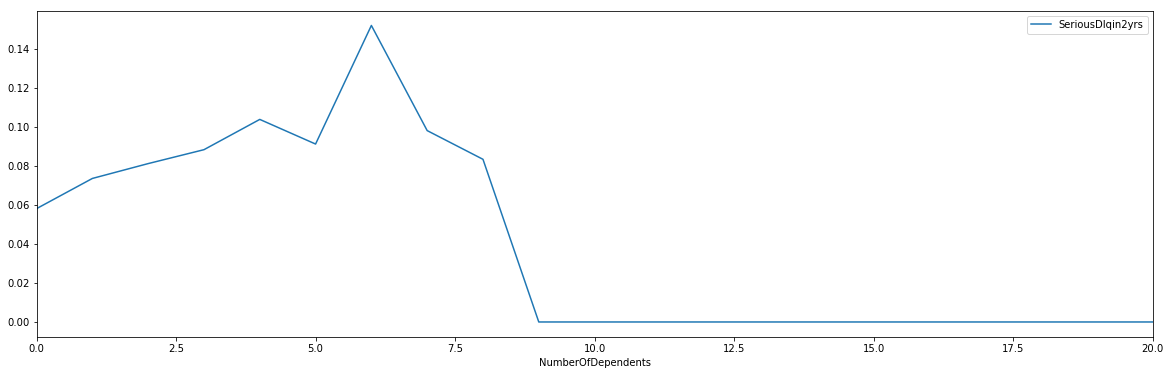

In [33]:
average_visualisation_groups(combined_dataset, ['NumberOfDependents', 'SeriousDlqin2yrs'], 'NumberOfDependents')

The above graph shows that serioues financial issues particularly plague individuals with between 5-7.5 dependents.

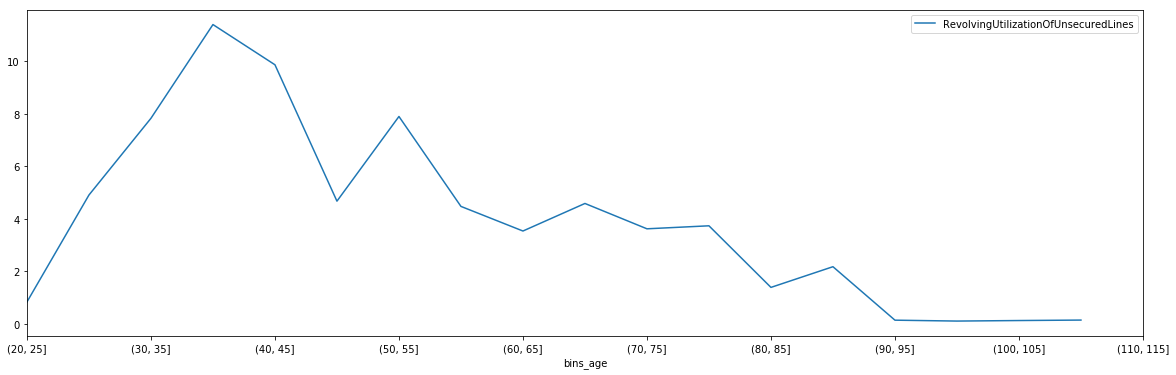

In [34]:
average_visualisation_groups(combined_dataset, [age_bucket, "RevolvingUtilizationOfUnsecuredLines"], age_bucket)

The above graph show's the revolving credit rates distributed by age. Revolving credit can be viewed as Credit-to-Debt Ratio. It can be expected that this graph will spike around 35 to 40 and slowly taper off.

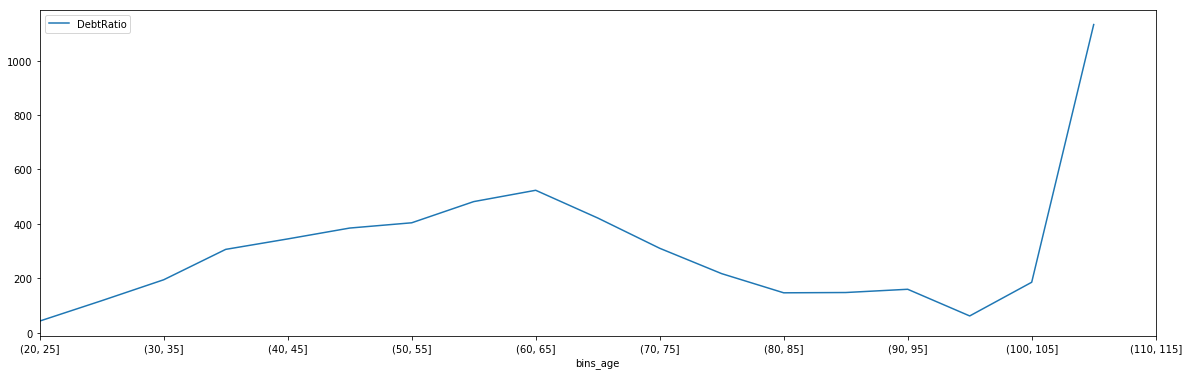

In [35]:
average_visualisation_groups(combined_dataset, [age_bucket, "DebtRatio"], age_bucket)

Above we see rising rates of debt ratio that begin to fall around 65 years of age (retirement) and then sharply increase towards the end of life.

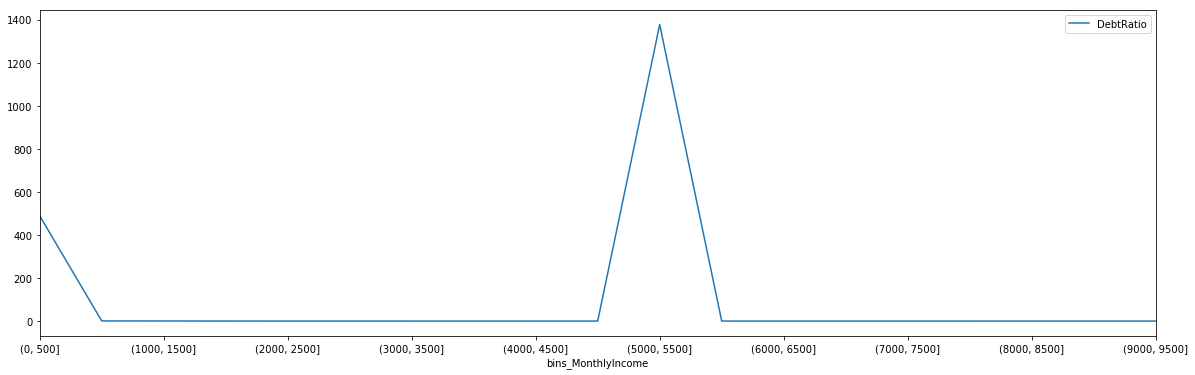

In [36]:
income_bins = range(0, 10000, 500)
income_bucket = generate_bins(combined_dataset, 'MonthlyIncome', income_bins)
average_visualisation_groups(combined_dataset, [income_bucket, "DebtRatio"], income_bucket)

It is important to note that this spike at $(5000, 5500]$ is due to our imputation - this is NOT naturally occuring.

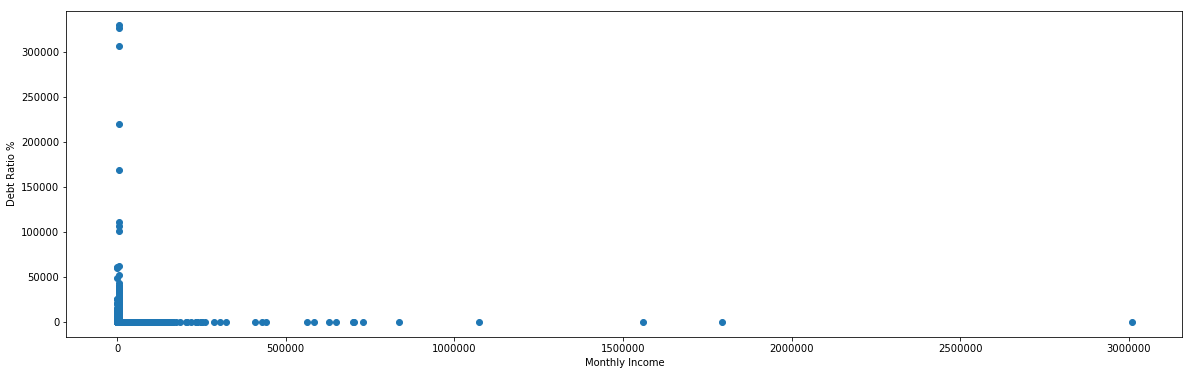

In [37]:
plt.scatter(combined_dataset['MonthlyIncome'], combined_dataset['DebtRatio'])
plt.xlabel("Monthly Income")
plt.ylabel("Debt Ratio %")

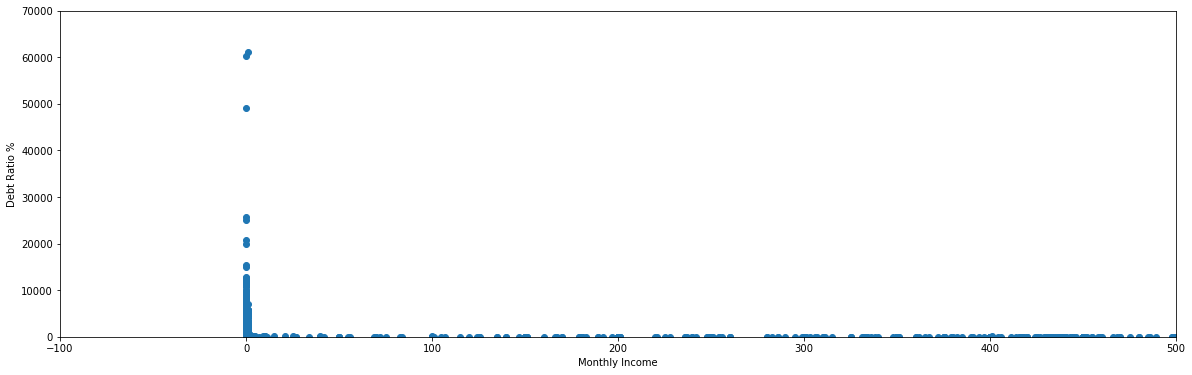

In [38]:
plt.scatter(combined_dataset['MonthlyIncome'], combined_dataset['DebtRatio'])
plt.xlim([-100,500])#limit monthly income to $2500K
plt.ylim([0, 70000]) #limit debt ratio to 50K%
plt.xlabel("Monthly Income")
plt.ylabel("Debt Ratio %")

These results are quite surpising. To put it into perspective, an individual with 100% debt ratio owes double of their total available credit! Thus, an individual with 20,000% owes 400 times more than all available credit!

We see a naturally occuring spike at 0. This could be due to individuals that are students.

Furthermore, while these results seem unusual, after doing some research, this debt ratio most likely contains the cost of credit cards, several mortgages, college tuition etc. Thus, we can expect extremly large ratio's. For my analysis, I will scale the debt ratio! Let's do that right now

In [39]:
X_train['DebtRatio'] = StandardScaler().fit_transform(X_train['DebtRatio'])
X_test['DebtRatio'] = StandardScaler().fit_transform(X_test['DebtRatio'])

(0, 250000)

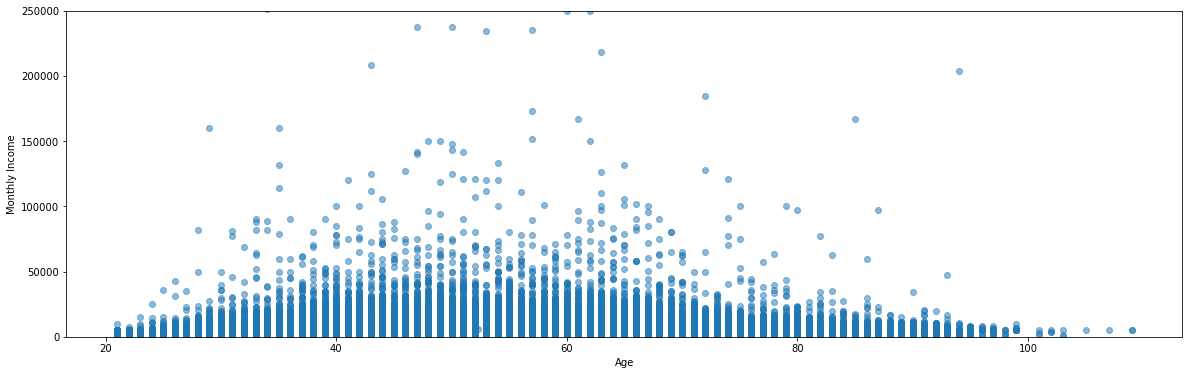

In [40]:
plt.scatter(combined_dataset['age'], combined_dataset['MonthlyIncome'], alpha=.5)
plt.xlabel("Age")
plt.ylabel("Monthly Income")
plt.ylim([0,250000])

(0, 5100)

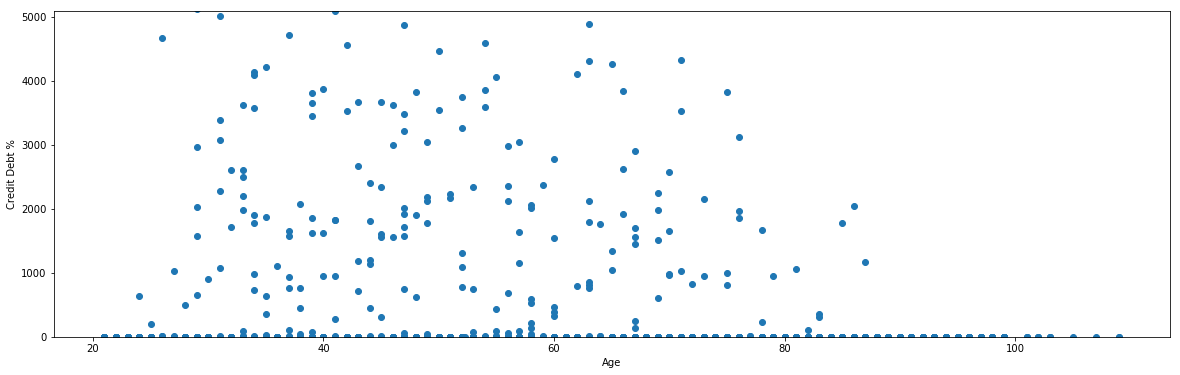

In [41]:
plt.scatter(combined_dataset['age'], combined_dataset['RevolvingUtilizationOfUnsecuredLines'])
plt.xlabel("Age")
plt.ylabel("Credit Debt %")
plt.ylim([0,5100])

I will also scale the monthly income and revolving utilisation of credit due to the high variability!.

Let's go ahead and do this!

In [42]:
X_train['MonthlyIncome'] = StandardScaler().fit_transform(X_train['MonthlyIncome'])
X_test['MonthlyIncome'] = StandardScaler().fit_transform(X_test['MonthlyIncome'])

In [43]:
X_train['RevolvingUtilizationOfUnsecuredLines'] = StandardScaler().fit_transform(X_train['RevolvingUtilizationOfUnsecuredLines'])
X_test['RevolvingUtilizationOfUnsecuredLines'] = StandardScaler().fit_transform(X_test['RevolvingUtilizationOfUnsecuredLines'])

In [44]:
combined_dataset.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,bins_MonthlyIncome,bins_age
0,1,0.766127,45.0,2,0.802982,9120.0,13,0,6,0,2.0,"(9000, 9500]","(40, 45]"
1,0,0.957151,40.0,0,0.121876,2600.0,4,0,0,0,1.0,"(2500, 3000]","(35, 40]"
2,0,0.658180,38.0,1,0.085113,3042.0,2,1,0,0,0.0,"(3000, 3500]","(35, 40]"
3,0,0.233810,30.0,0,0.036050,3300.0,5,0,0,0,0.0,"(3000, 3500]","(25, 30]"
4,0,0.907239,49.0,1,0.024926,63588.0,7,0,1,0,0.0,NaN,"(45, 50]"


One last thing to check for is multicollinearity of our features! Let's loop through our dataframe and check!

In [45]:
for i in combined_dataset.columns[:-2]:
    print("Correlation Matrix for : ", i)
    print()
    print(combined_dataset.corr().unstack()[i])
    print()

Correlation Matrix for :  SeriousDlqin2yrs

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines   -0.001802
age                                    -0.115397
NumberOfTime30-59DaysPastDueNotWorse    0.125587
DebtRatio                              -0.007602
MonthlyIncome                          -0.017146
NumberOfOpenCreditLinesAndLoans        -0.029669
NumberOfTimes90DaysLate                 0.117175
NumberRealEstateLoansOrLines           -0.007038
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046869
dtype: float64

Correlation Matrix for :  RevolvingUtilizationOfUnsecuredLines

SeriousDlqin2yrs                       -0.001802
RevolvingUtilizationOfUnsecuredLines    1.000000
age                                    -0.005899
NumberOfTime30-59DaysPastDueNotWorse   -0.001314
DebtRatio                               0.003961
MonthlyIncome                           0.006513
NumberOfOpenCreditLinesAndLoans        -0.0

Inspecting the above printout show us some very strong correlation between being 30-59 days past due with being 60-90+ days due. Around correlation coeff of around 0.9~. This is to be expected as the days are related to each other and are thus autoregressive. Furthermore, these categories are all 0 in the Inter-quartile Range.

However, we should not be including highly correlated variables in our models as each highly correlated variable is simply introducing noise into our model and no incremental information. I will drop the 60-89 and 90+ day categories.

Another interesting finding is between the number of open lines of credit and Real Estate with a correlation coefficient of 0.434. However, this is not sufficently high for me to drop the variable. Ideally, I would find a another variable to control for this

Let's proceed to drop our highly correlated cariables.

In [46]:
del X_train['NumberOfTime60-89DaysPastDueNotWorse']
del X_train['NumberOfTimes90DaysLate']
del X_test['NumberOfTime60-89DaysPastDueNotWorse']
del X_test['NumberOfTimes90DaysLate']

The assignment specifically asks for the creation of function that can turn a categorical variable and turn it into a binary variable. I will create the function below, however, it will NOT be used in model creation/evaluation. I would have used this function to create dummy variables for Zip Codes.

I just want to note that the pd.get_dummies function is amazing. If I wasnt aware of this function I would have used the onehotencoder class from the sklearn library.

In [47]:
def create_binary(df, column, remove_original_col = False):
    '''
    Takes a Dataframe, a column in the dataframe and returns dummy variables
    for that column. Optional argument to remove origianl column from dataframe
    after dummy variable creation.
    '''
    
    if remove_original_col:
        df_col = pd.get_dummies(df[column])
        binary_df = pd.concat([df, df_col], axis=1)
        del binary_df[column]
        return binary_df
    else:
        df_col = pd.get_dummies(df[column])
        binary_df = pd.concat([df, df_col], axis=1)
        return binary_df

# **Part 5/6**

Let's get our features and label in the appropriate form to be fed into out ML algo.

When we extract the values from our dataframe - we will lose our headers. As such, let's make a reference of these headers so we can access them easily later on.

In [48]:
reference = {}
for i, val in enumerate(X_train.columns):
    if i not in reference.keys():
        reference[i] = val

In [49]:
reference

{0: 'RevolvingUtilizationOfUnsecuredLines',
 1: 'age',
 2: 'NumberOfTime30-59DaysPastDueNotWorse',
 3: 'DebtRatio',
 4: 'MonthlyIncome',
 5: 'NumberOfOpenCreditLinesAndLoans',
 6: 'NumberRealEstateLoansOrLines',
 7: 'NumberOfDependents'}

Here we are extracting the values from our dataframe. The code below returns numpy arrays which is exactly the correct pbject type we need to feed into our Ml algo's.

In [50]:
X_train = X_train.iloc[:, :].values
X_test = X_test.iloc[:,:].values
y_train = y_train.iloc[:, 0].values
y_test = y_test.iloc[:, 0].values

SKLearn requires that the you label variable of type category - while we could have converted this directly in the dataframe by using .astype, it is just as easy to use the LabelEncoder class. This way, we dont have to worry about the intermediate object types of y as we pass through our EDA phase. Labelencoder will ensure everything is ready just before our model creation

In [51]:
labelencoder_y_train = LabelEncoder()
labelencoder_y_test = LabelEncoder()
y_train = labelencoder_y_train.fit_transform(y_train)
y_test = labelencoder_y_test.fit_transform(y_test)

We now turn our attention to building our models.

I will use Recursive Feature Elimaination for a Logistic Regression Model and an ensemble method called Extra Trees Classifier which both selectes the best features and then runs the model.

I have also included Random Forest classifier and the Gradient Boosting Classifier - these are just additional models we could have run. Including them is merely an excerise in my ability to implement these models with code.

My function below will extract the most appropriate model based on accuracy score. Accuracy score is actually not the best metric, however, for the purposes of this assignmet, I am omitting cross validation techniques that would deliver more approriate metrics to judge between models. An alternative implementation would be to assess the area under the ROC Curve for each model and then pick according to that.

In future assignments, I will use a more sophisticated version of the below function.

Running Logistic Regression Model

Running Extra Tree's Classifier

Running Random Forest Classifier

Running Gradient Boosting Classifier

--**Evaluating Best Model**--

The Best model is:  Logisitic Regression with an accuracy score of:  0.932200560823
Best Feature Columns:

NumberOfTime30-59DaysPastDueNotWorse

DebtRatio

MonthlyIncome

NumberOfDependents

Classification Report: 

             precision    recall  f1-score   support

          0       0.93      1.00      0.96     27915
          1       0.61      0.01      0.03      2041

avg / total       0.91      0.93      0.90     29956


Confusion Matricies: 

Regular Confusion matrix
[[27897    18]
 [ 2013    28]]



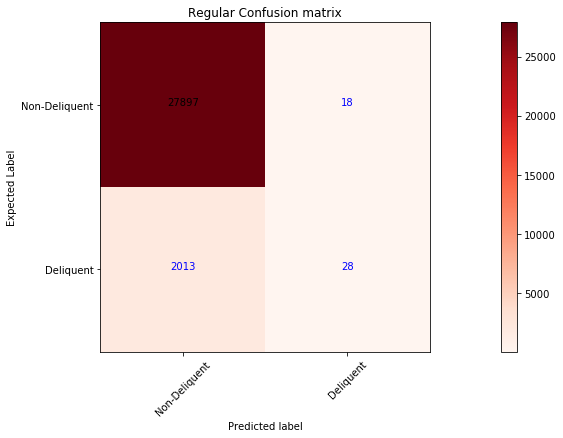


Normalized confusion matrix
[[  9.99e-01   6.45e-04]
 [  9.86e-01   1.37e-02]]



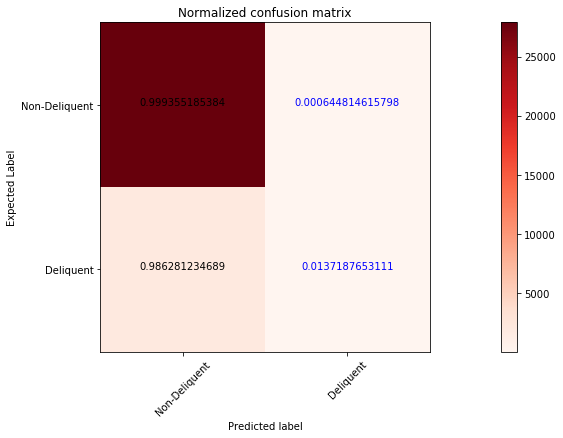


ROC Curve: 



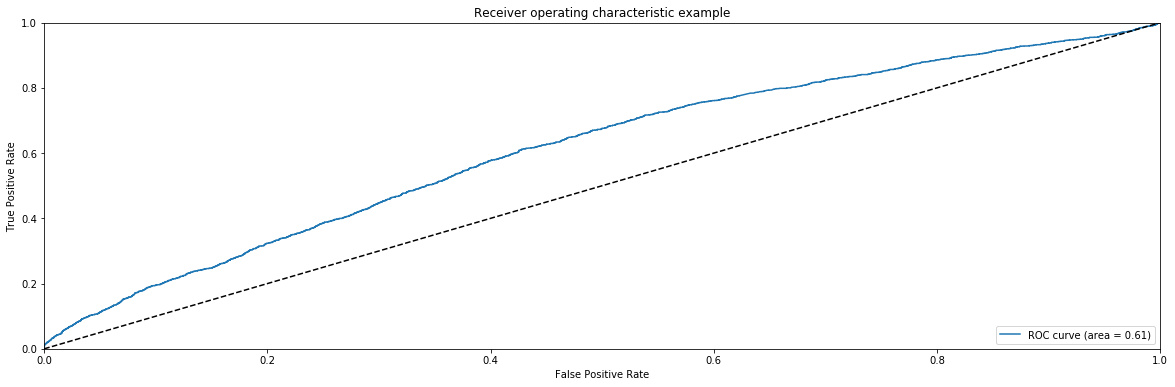

In [52]:
extract_best_model(X_train, X_test, y_train, y_test, reference)